<a href="https://colab.research.google.com/github/farzin23i/SuperResolution_DeepCNN/blob/main/Main_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pylab as plt
import seaborn as sns
import pandas as pd
from glob import glob
import os
import cv2 

In [ ]:
%cd /content/drive/MyDrive/PNSH/SuperR

/content/drive/MyDrive/PNSH/SuperR


In [ ]:
# !pip install patool
# import patoolib
# patoolib.extract_archive("test.rar")

In [ ]:
# !unrar x "train.rar" -d Images

In [ ]:
np.unique([name.split ('.')[-1] for name in glob('Images/train/*')])

array(['JPEG', 'jpg', 'lnk'], dtype='<U4')

In [ ]:
path = 'Images/train/*.lnk'
nm= glob(path)
for n in nm: 
    os.remove (f'{n}')
    print (n)

Images/train/n12985857_10703 - Shortcut.lnk


In [ ]:
glob(path)

[]

In [ ]:
path = 'Images/train/*'
names = glob(path)
total_train = len(names)
total_train

1499

In [ ]:
path_test = 'Images_test/test/*'
names_test = glob(path_test)
total_test = len(names_test)
total_test

278

In [ ]:
sh = []
for i, name in enumerate(names):
    img = cv2.imread(name)
    sh.append(img.shape)

sh = np.array (sh)

In [ ]:
df= pd.DataFrame (sh)
df.describe ()

,0,1,2
count,1499.000000,1499.000000,1499.0
mean,364.220814,498.863909,3.0
std,37.189443,12.936278,0.0
min,321.000000,481.000000,3.0
25%,333.000000,500.000000,3.0
50%,375.000000,500.000000,3.0
75%,375.000000,500.000000,3.0
max,534.000000,650.000000,3.0


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
INPUT_WIDTH = 300
INPUT_HEIGHT = 200
INPUT_SIZE = (INPUT_HEIGHT, INPUT_WIDTH)

IMAGE_CHANNELS=3

X_train_datagen = ImageDataGenerator(
    rescale= 1./255,)

y_train_datagen = ImageDataGenerator(
    rescale= 1./255,)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Dropout, BatchNormalization, Resizing, Concatenate, ZeroPadding2D
from tensorflow.keras.utils import plot_model

In [ ]:
drp_rate = 0.3

input = Input(shape= (INPUT_HEIGHT, INPUT_WIDTH, IMAGE_CHANNELS))
# input1 = Input(shape= (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS))

x = UpSampling2D ((3,3))(input)
# x = BatchNormalization()(x)

x = Conv2D (64, (9,9), activation='relu', strides=(2,2))(x)
x = ZeroPadding2D(padding=(6,6))(x)
x = BatchNormalization()(x)
x = Dropout(drp_rate)(x)

x = Conv2D (32, (5,5), activation='relu',)(x)
x = ZeroPadding2D(padding=(6,6))(x)
x = BatchNormalization()(x)
x = Dropout(drp_rate)(x)

x = Conv2D (3, (5,5), activation='relu',)(x)
x = ZeroPadding2D(padding=(6,6))(x)
x = BatchNormalization()(x)

# x = UpSampling2D ((3,3))(x)


x1 = Resizing(x.shape[1], x.shape[2], interpolation="bicubic")(input)
# x3 = Resizing(x.shape[1], x.shape[2], interpolation="nearest")(input)
x2 = Concatenate (axis= -1)([x, x1])

x2 = Conv2D (64, (9,9), activation='relu',)(x2)
x2 = ZeroPadding2D(padding=(4,4))(x2)
x2 = BatchNormalization()(x2)
x2 = Dropout(drp_rate)(x2)

x2 = Conv2D (32, (5,5), activation='relu',)(x2)
x2 = ZeroPadding2D(padding=(4,4))(x2)
x2 = BatchNormalization()(x2)
x2 = Dropout(drp_rate)(x2)

x2 = Conv2D (3, (5,5), activation='relu',)(x2)

model = Model(inputs= input, outputs= x2)
model.compile(loss='MSE', optimizer='adam')


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 200, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 up_sampling2d_8 (UpSampling2D)  (None, 600, 900, 3)  0          ['input_9[0][0]']                
                                                                                                  
 conv2d_48 (Conv2D)             (None, 296, 446, 64  15616       ['up_sampling2d_8[0][0]']        
                                )                                                                 
                                                                                            

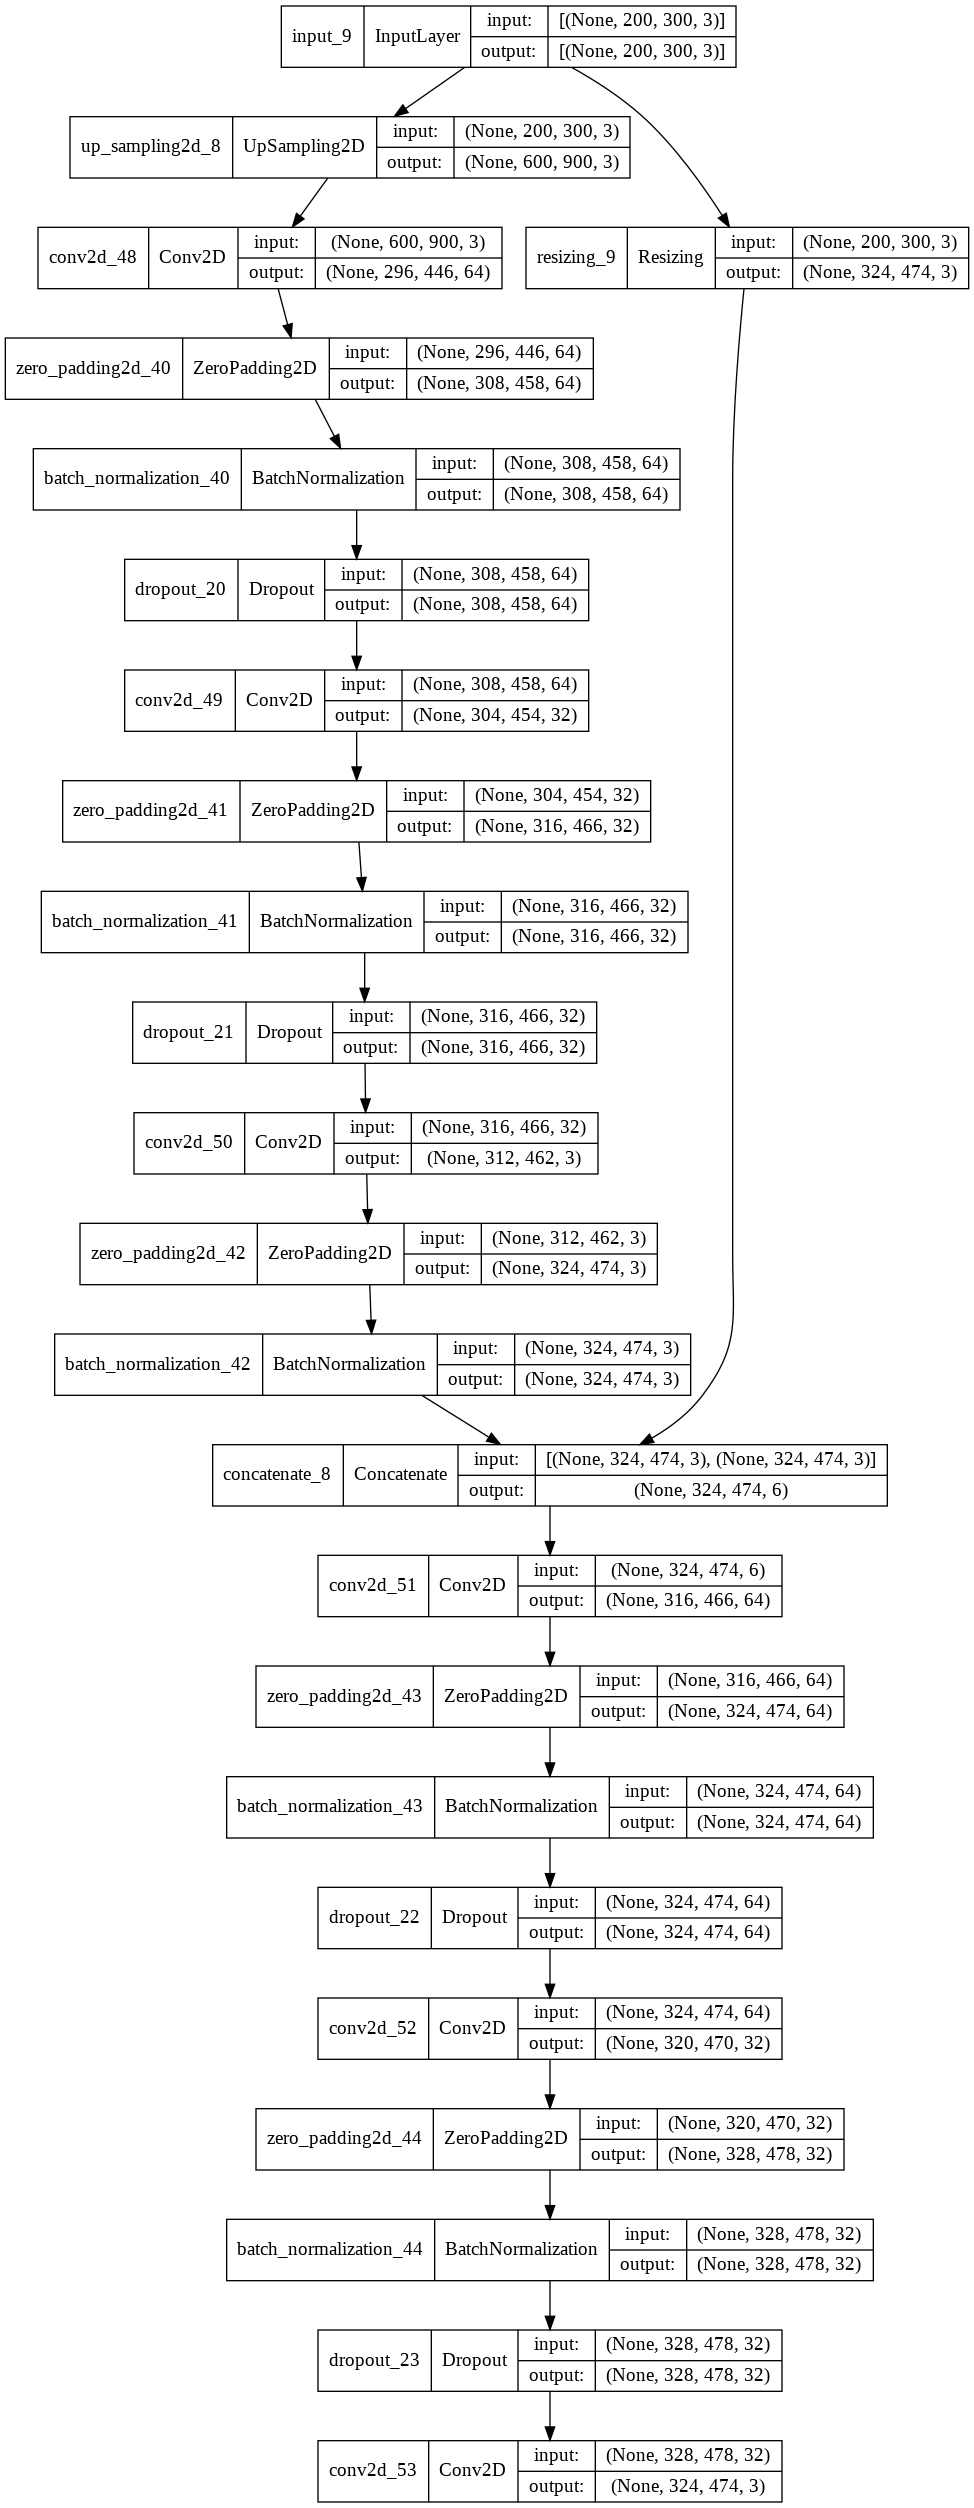

In [ ]:
print (model.summary())
plot_model(model, show_shapes=True)

In [ ]:
IMAGE_SIZE=list(x2.shape [1:3])
batch_size = 16
batch_size_test = 64
seed = 100 # Important

X_train_generator = X_train_datagen.flow_from_directory(
    'Images',
    target_size= INPUT_SIZE,
    batch_size=batch_size,
    class_mode= None,
    seed=seed
    )

y_train_generator = y_train_datagen.flow_from_directory(
    'Images',
    target_size= IMAGE_SIZE,
    batch_size=batch_size,
    class_mode= None,
    seed=seed
    )


X_test_generator = X_train_datagen.flow_from_directory(
    'Images_test',
    target_size= INPUT_SIZE,
    batch_size=batch_size_test,
    class_mode= None,
    seed=seed
    )

y_test_generator = y_train_datagen.flow_from_directory(
    'Images_test',
    target_size= IMAGE_SIZE,
    batch_size=batch_size_test,
    class_mode= None,
    seed=seed
    )

train_generator = zip(X_train_generator, y_train_generator)
test_generator = zip(X_test_generator, y_test_generator)

Found 1499 images belonging to 1 classes.
Found 1499 images belonging to 1 classes.
Found 278 images belonging to 1 classes.
Found 278 images belonging to 1 classes.


In [ ]:
history = model.fit (train_generator, epochs=15, verbose=1, 
           steps_per_epoch= total_train//batch_size,)

Epoch 1/15
93/93 [==============================] - 184s 2s/step - loss: 0.0980
Epoch 2/15
93/93 [==============================] - 183s 2s/step - loss: 0.0479
Epoch 3/15
93/93 [==============================] - 183s 2s/step - loss: 0.0368
Epoch 4/15
93/93 [==============================] - 183s 2s/step - loss: 0.0293
Epoch 5/15
93/93 [==============================] - 182s 2s/step - loss: 0.0252
Epoch 6/15
93/93 [==============================] - 182s 2s/step - loss: 0.0175
Epoch 7/15
93/93 [==============================] - 183s 2s/step - loss: 0.0174
Epoch 8/15
93/93 [==============================] - 183s 2s/step - loss: 0.0146
Epoch 9/15
93/93 [==============================] - 183s 2s/step - loss: 0.0122
Epoch 10/15
93/93 [==============================] - 183s 2s/step - loss: 0.0135
Epoch 11/15
93/93 [==============================] - 183s 2s/step - loss: 0.0137
Epoch 12/15
93/93 [==============================] - 183s 2s/step - loss: 0.0113
Epoch 13/15
93/93 [==================

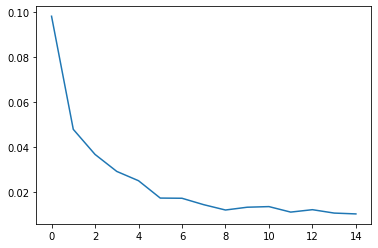

In [ ]:
plt.plot (history.history['loss'])

2/2 - 5s - 5s/epoch - 3s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


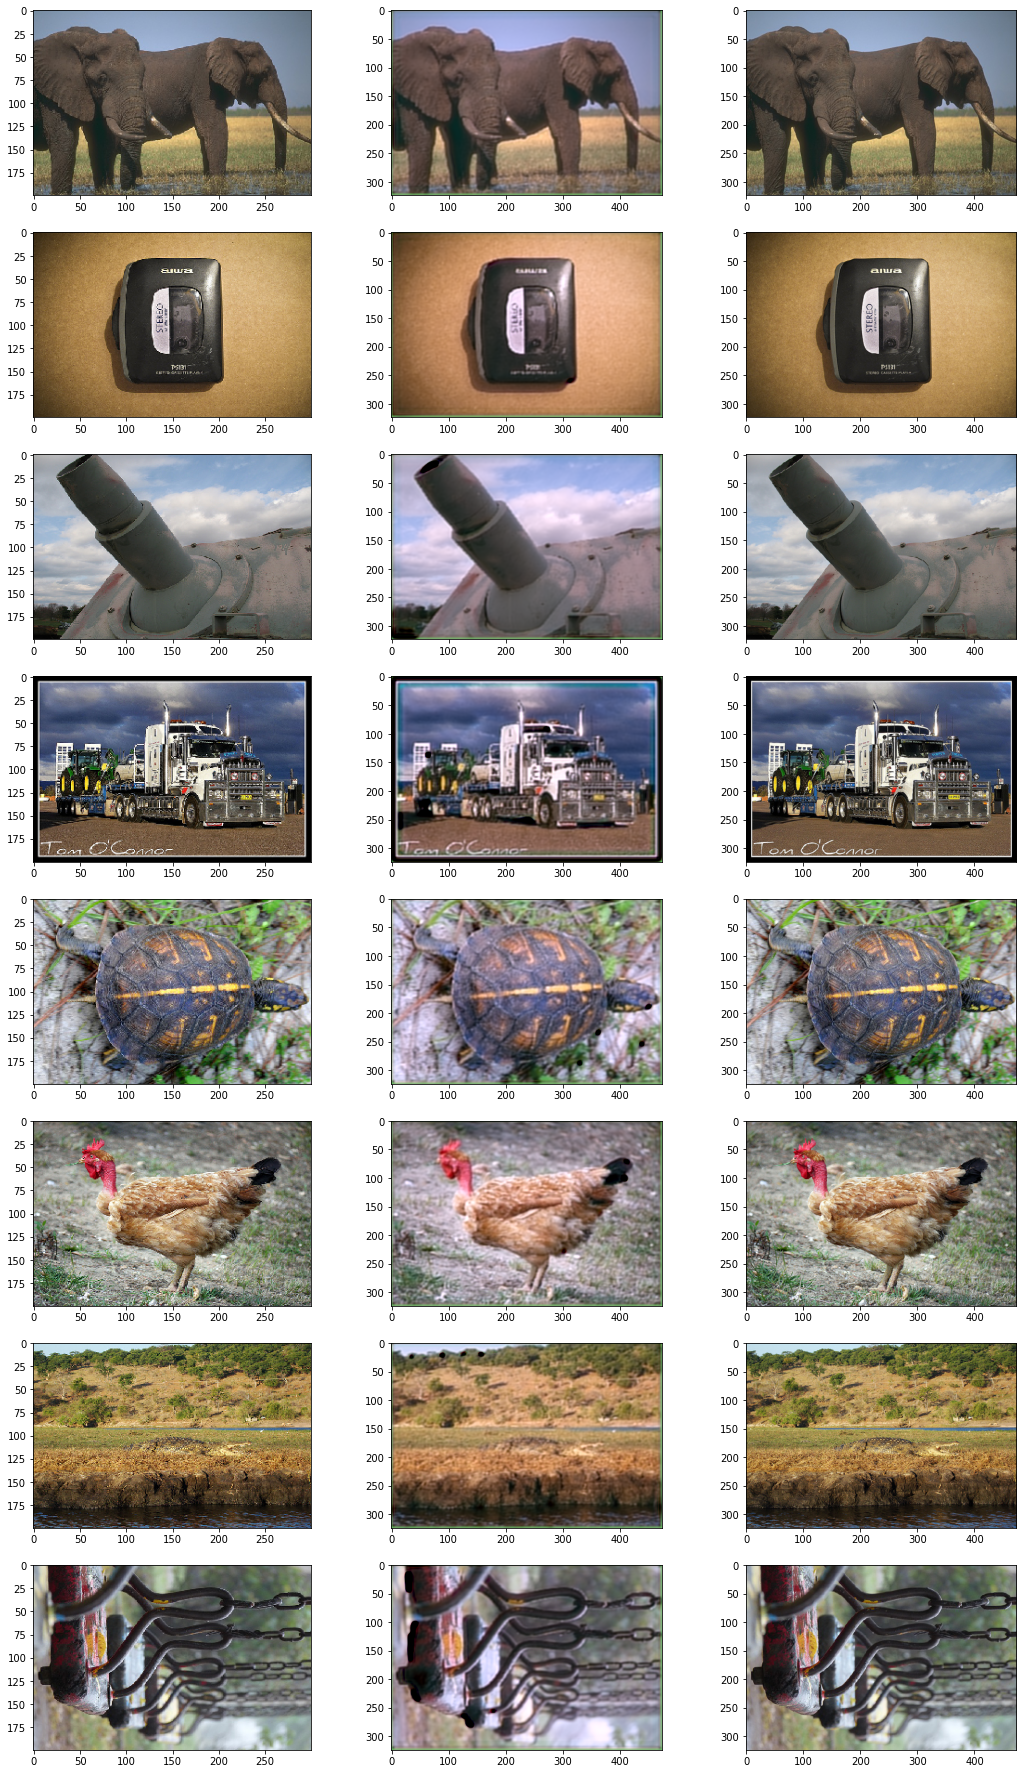

In [ ]:
in_imgs= next(X_test_generator)
imgs= next(y_test_generator)
pred = model.predict (in_imgs, verbose=2)

n= 8
fig, ax= plt.subplots (n, 3, figsize=(18, 4*n))

for i in range (n):
    ax[i, 0].imshow (in_imgs[i])
    ax[i, 1].imshow (pred[i])
    ax[i, 2].imshow (imgs[i])
    
plt.show ()

In [ ]:
def MSError(original, prediction):
    return np.sum((original-prediction)**2)/np.prod(imgs.shape)

In [ ]:
from math import log10, sqrt
import cv2
import numpy as np
  
def PSNR(original, prediction):
    mse = np.mean((original - prediction) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 1
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

In [ ]:
# for i, j in range (total_train//batch_size):
c= 0
mse= []
psnr= []
for in_img, img in test_generator:
    # in_imgs, imgs= next(test_generator)
    # imgs= next(y_test_generator)
    c+=1 
    pred = model.predict (in_img, verbose=2)
    mse.append(MSError (img, pred))
    pnsr.append(PSNR(img, pred))
    if c >= total_test//batch_size_test:
        break

2/2 - 1s - 1s/epoch - 744ms/step
2/2 - 1s - 1s/epoch - 697ms/step
1/1 - 3s - 3s/epoch - 3s/step
2/2 - 1s - 1s/epoch - 697ms/step


In [ ]:
mserr = np.mean (mse)
pnsr_ = np.mean(pnsr)
print (f'Fot {total_test} test images, the Mean Squared Errot is {mserr} and PNSR is {pnsr_}')

Fot 278 test images, the Mean Squared Errot is 0.007028778723182048 and PNSR is 20.9515079672867
